In [44]:
import outlines
import io
from datasets import load_dataset
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [45]:
# Load dataset with Hugging Face
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

In [46]:
dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'ground_truth': Value(dtype='string', id=None)}

Original Image:


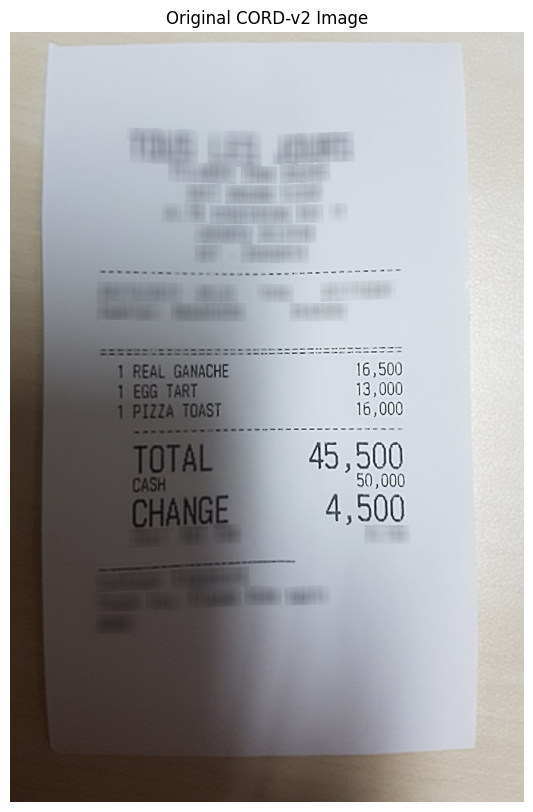


Ground Truth JSON (partial):
{
  "menu": [
    {
      "nm": "REAL GANACHE",
      "cnt": "1",
      "price": "16,500"
    },
    {
      "nm": "EGG TART",
      "cnt": "1",
      "price": "13,000"
    },
    {
      "nm": "PIZZA TOAST",
      "cnt": "1",
      "price": "16,000"
    }
  ],
  "total": {
    "total_price": "45,500",
    "cashprice": "50,000",
    "changeprice": "4,500"
  }
}...


In [47]:
sample_image_data = dataset[0] # Take the first example
sample_image_pil = sample_image_data["image"].convert("RGB") # Ensure it's RGB
ground_truth_json_str = sample_image_data["ground_truth"]
ground_truth_dict = json.loads(ground_truth_json_str)

print("Original Image:")
plt.figure(figsize=(8, 10))
plt.imshow(sample_image_pil)
plt.axis('off')
plt.title("Original CORD-v2 Image")
plt.show()

print("\nGround Truth JSON (partial):")
# Pretty print a part of the ground truth for understanding
print(json.dumps(ground_truth_dict["gt_parse"], indent=2)[:500] + "...") # Show first 500 chars

In [48]:
from transformers import AutoProcessor, AutoModel

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base")

processor

LayoutLMv3Processor:
- image_processor: LayoutLMv3ImageProcessor {
  "apply_ocr": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstr

In [49]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")

encoding = processor.image_processor(sample_image_pil)
encoding

{'pixel_values': [array([[[ 0.54509807,  0.54509807,  0.54509807, ...,  0.6627451 ,
          0.654902  ,  0.64705884],
        [ 0.54509807,  0.54509807,  0.54509807, ...,  0.654902  ,
          0.64705884,  0.64705884],
        [ 0.54509807,  0.5529412 ,  0.5529412 , ...,  0.64705884,
          0.654902  ,  0.654902  ],
        ...,
        [-0.6313726 , -0.6156863 , -0.62352943, ...,  0.5764706 ,
          0.58431375,  0.5921569 ],
        [-0.6313726 , -0.62352943, -0.62352943, ...,  0.5921569 ,
          0.58431375,  0.6       ],
        [-0.62352943, -0.62352943, -0.6156863 , ...,  0.5764706 ,
          0.5764706 ,  0.58431375]],

       [[ 0.5137255 ,  0.5137255 ,  0.5137255 , ...,  0.654902  ,
          0.64705884,  0.6392157 ],
        [ 0.5137255 ,  0.5058824 ,  0.5137255 , ...,  0.6392157 ,
          0.64705884,  0.6392157 ],
        [ 0.5137255 ,  0.52156866,  0.52156866, ...,  0.6392157 ,
          0.64705884,  0.6392157 ],
        ...,
        [-0.75686276, -0.75686276, -

In [50]:
image_processor = processor.image_processor

def get_ocr_words_and_boxes(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    encoded_inputs = image_processor(images)

    examples["image"] = encoded_inputs.pixel_values
    examples["words"] = encoded_inputs.words
    examples["boxes"] = encoded_inputs.boxes

    return examples

In [51]:
dataset_with_ocr = dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2)

In [52]:
tokenizer = processor.tokenizer

In [53]:
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i : i + len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
        return matches[0], start_indices[0], end_indices[0]
    else:
        return None, 0, 0

In [54]:
dataset_with_ocr[1]

{'image': [[[0.058823585510253906,
    0.050980448722839355,
    0.058823585510253906,
    0.050980448722839355,
    0.043137311935424805,
    0.035294175148010254,
    0.027451038360595703,
    -0.019607841968536377,
    -0.011764705181121826,
    -0.019607841968536377,
    -0.003921568393707275,
    -0.03529411554336548,
    -0.019607841968536377,
    -0.03529411554336548,
    -0.05098038911819458,
    -0.04313725233078003,
    -0.08235293626785278,
    -0.07450979948043823,
    -0.04313725233078003,
    -0.019607841968536377,
    -0.011764705181121826,
    -0.07450979948043823,
    -0.08235293626785278,
    -0.06666666269302368,
    -0.03529411554336548,
    -0.06666666269302368,
    -0.13725489377975464,
    -0.1921568512916565,
    -0.1450980305671692,
    -0.15294116735458374,
    -0.19999998807907104,
    -0.18431371450424194,
    -0.1921568512916565,
    -0.18431371450424194,
    -0.21568626165390015,
    -0.2078431248664856,
    -0.1450980305671692,
    -0.1764705777168274,
  

Use this resource

- https://huggingface.co/docs/transformers/en/model_doc/layoutlmv2
- https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/CORD/Fine_tuning_LayoutLMv2ForTokenClassification_on_CORD.ipynb